# Assignment 7
Daniel Boyea | Astronomy 507 | 22 March 2024

Here is my assignment. Since this is very similar to the procedure for my thesis, I did not use Sangiovese but instead COSMA (in Durham) for the simulation so others could use that resource. Also, my code / setup is slightly different than Rapha's so hopefully this is okay but I understand if you would like any additional files or have any questions.

I keep each model in a seperate directory structured as follows. The output of the shrinking spheres model is in "centres.csv" as a table with positions, velocities, and times for each snapshot. The snapshots are instead in "out".

For this assignment, I did run simulations with different initial masses attempting to create models with different survivale times. I also calculated the circular orbit and run that model.

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from glob import glob as glob

In [2]:
# all of these are just figure aesthetics...
COLORS = ["#0173b2", "#de8f05", "#029e73", "#d55e00", "#cc78bc", "#ca9161", "#fbafe4", "#949494", "#ece133", "#56b4e9"]
plt.style.use("journal.mplstyle")
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=COLORS)
rcParams = plt.rcParams
rcParams["figure.dpi"] = 200
rcParams["pdf.fonttype"] = 42

rcParams["text.usetex"] = True
rcParams["mathtext.fontset"] = "custom"
rcParams["text.latex.preamble"] = "\\usepackage{amsmath} \\usepackage{txfonts} \\usepackage[T1]{fontenc}"
rcParams["axes.formatter.use_mathtext"] = True
rcParams["font.family"] = "serif"
rcParams["text.antialiased"] = True

lw= 1
ms = 2
L = 10/3
l = L/2
rcParams["lines.linewidth"] = lw
rcParams["lines.markersize"] = ms
rcParams["axes.linewidth"] = lw
rcParams["xtick.major.width"] = lw
rcParams["ytick.major.width"] = lw
rcParams["xtick.minor.width"] = lw/2
rcParams["ytick.minor.width"] = lw/2

rcParams["xtick.major.size"] = L
rcParams["ytick.major.size"] = L
rcParams["xtick.minor.size"] = l
rcParams["ytick.minor.size"] = l
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"
rcParams["xtick.top"] = True
rcParams["ytick.right"] = True
rcParams["xtick.minor.visible"] = True
rcParams["ytick.minor.visible"] = True
rcParams["xtick.minor.top"] = True

In [3]:
# unit system
R0 = 1 # kpc
V0 = 207.4 # u.km/u.s
T0 = 4.718e-3 # u.Gyr
M0 = 1e10 # u.Msun

In [4]:
def get_N_snapshots(directory):
    """returns the number of snapshots in directory/out"""
    return len(glob(directory + "/out/snapshot*.hdf5"))

In [5]:
def get_radii(snap, centre=np.zeros(3)):
    """returns the radius of each particle in a snapshot optionally with a given centre"""
    dx = get_positions(snap) - centre.reshape((-1, 1))
    return np.sqrt(np.sum(dx**2, axis=0))

def get_positions(snap):
    """returns the positions of each particle in the snapshot as a np.array"""
    return np.array(snap["PartType1/Coordinates"]).transpose()

def get_snap_name(directory, i):
    """returns the name of the ith snapshot in the given model directory"""
    return directory + f"/out/snapshot_{str(i).zfill(3)}.hdf5"

def get_snap(filename):
    """Returns the hdf5 file from a given filename"""
    F = h5py.File(filename, "r")
    return F

def get_part_mass(directory):
    """Returns the mass of a particle from the given model directory (assuming equal, constant masses)"""
    F = get_snap(get_snap_name(directory, 0))
    m = F["PartType1/Masses"][0]
    return m

In [6]:
def get_centres(directory):
    """ returns the file containing the centres from the directory """
    return pd.read_csv(directory + "/centres.csv")

def get_x_cen(directory):
    """Returns a np array of the centres of the snapshots"""
    cens = get_centres(directory)
    return np.array([cens.x, cens.y, cens.z])

In [7]:
def calc_M_inside(directory, radius=0.010):
    """Calculates the total inside the given radius for each snapshot in the directory"""
    centres = get_x_cen(directory)
    N = get_N_snapshots(directory)
    Mins = np.zeros(N)
    m = get_part_mass(directory)
    
    for i in range(N):
        filename = get_snap_name(directory, i)
        snap = get_snap(filename)

        rs = get_radii(snap, centres[:, i])
        count = np.sum(rs < radius)
        Mins[i] = count * m
        
    return Mins

## The circular model
Since we can determine the acceleration of the initial snapshot, and $v_{\rm circ} = \sqrt{G M /r} = \sqrt{a_{\rm G}*r}$, we can get the magnitude of the circular velocity, then project this onto the current tangent vector of the present velocity.

In [8]:
snap_i = get_snap("orbit1/out/snapshot_000.hdf5")

In [9]:
acceleration = np.mean(snap_i["PartType1/Acceleration"], axis=0)
x = np.mean(snap_i["PartType1/Coordinates"], axis=0)
v = np.mean(snap_i["PartType1/Velocities"], axis=0)

a = np.sqrt(np.sum(acceleration**2))
r = np.sqrt(np.sum(x**2))

In [10]:
v_circ = np.sqrt(r * a)
print(v_circ * V0)

v_t = v - np.dot(v, x) * x/ r**2
v_ini = v_t / np.sqrt(np.sum(v_t**2)) * v_circ

224.49247224330904


In [11]:
print("initial velocity: ", v_ini * V0)

initial velocity:  [  0.45927724 223.84134     17.079662  ]


Unsurprizingly, the circular velocity is about that at the local standard of rest for the Milky Way. 

## Orbital planes

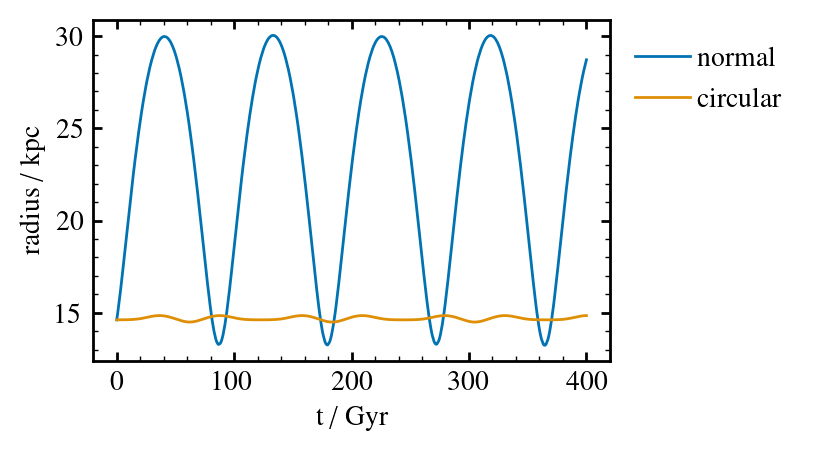

In [12]:
cen1 = get_centres("orbit1")
cenc = get_centres("orbitc")

r = np.sqrt(cen1.x**2 + cen1.y**2 + cen1.z**2)
plt.plot(cen1.t, r, label="normal")

r = np.sqrt(cenc.x**2 + cenc.y**2 + cenc.z**2)
plt.plot(cenc.t, r, label="circular")


plt.xlabel("t / Gyr")
plt.ylabel("radius / kpc")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1)) # outside legend


the orbit Rapha gave has a pericentre of about 14 and apocentre of 30 kpc. The circular orbit is not perfect but is close to the same radius throughout.

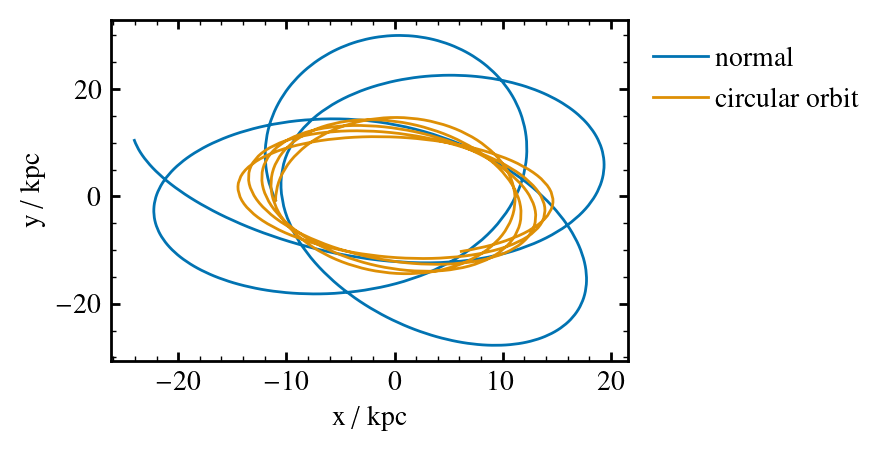

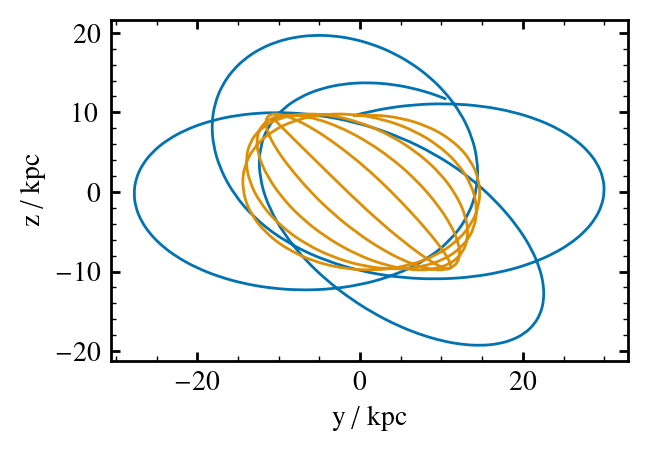

Text(0, 0.5, 'x / kpc')

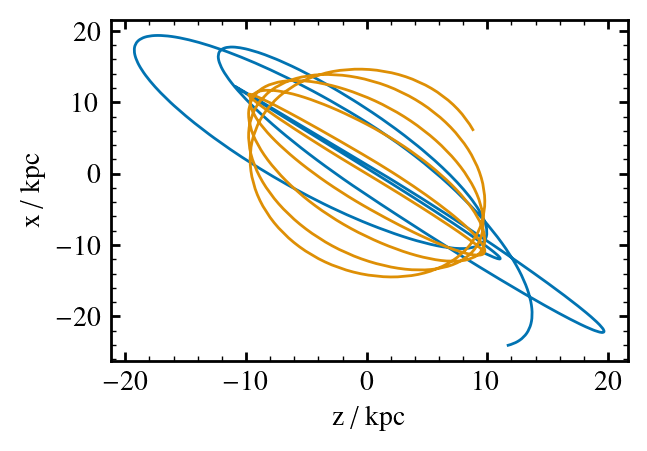

In [13]:
x_1 = get_x_cen("orbit1")
x_c = get_x_cen("orbitc")

plt.plot(x_1[0, :], x_1[1, :], label="normal")
plt.plot(x_c[0, :], x_c[1, :], label="circular orbit")
plt.xlabel("x / kpc")
plt.ylabel("y / kpc")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1)) # outside legend

plt.show()

plt.plot(x_1[1, :], x_1[2, :], label="normal")
plt.plot(x_c[1, :], x_c[2, :], label="circular orbit")
plt.xlabel("y / kpc")
plt.ylabel("z / kpc")
plt.show()

plt.plot(x_1[2, :], x_1[0, :], label="normal")
plt.plot(x_c[2, :], x_c[0, :], label="circular orbit")
plt.xlabel("z / kpc")
plt.ylabel("x / kpc")



the circular orbit processes and moves quite a bit in z (especially as z is fairly high initially). However, plotting the orbit in the R-z (polar) coordinates reveals that the orbit is quite circular in this projection.

(0.0, 40.0)

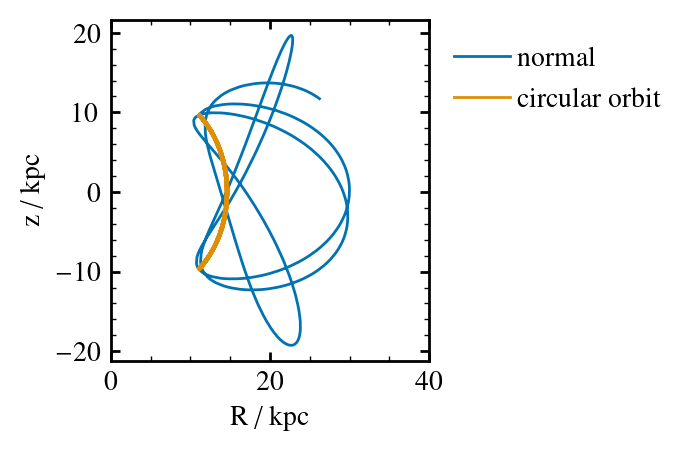

In [14]:
plt.subplot(aspect=1)
R = np.sqrt(x_1[0, :]**2 + x_1[1, :]**2)
plt.plot(R, x_1[2, :], label="normal")
R = np.sqrt(x_c[0, :]**2 + x_c[1, :]**2)
plt.plot(R, x_c[2, :], label="circular orbit")
plt.xlabel("R / kpc")
plt.ylabel("z / kpc")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1)) # outside legend
plt.xlim(0, 40)

# Mass Evoltuion

In [15]:
directories = ["orbit1", "orbit2", "orbit4", "orbit5"]
labels = [16, 80, 120, 140]
directory_c = "orbitc"

(0.1, 213.85427320595704)

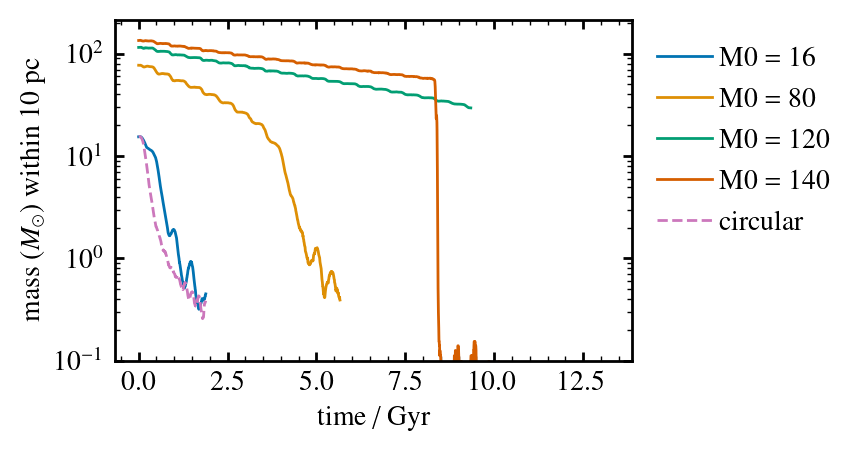

In [16]:
for i in range(len(directories)):
    Ms = calc_M_inside(directories[i])
    cen = get_centres(directories[i])
    plt.plot(cen.t * T0, Ms * M0, label=f"M0 = {labels[i]}")
    
Ms = calc_M_inside("orbitc")
cen = get_centres("orbitc")
plt.plot(cen.t * T0, Ms * M0, label="circular", ls="--")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1)) # outside legend
plt.xlabel("time / Gyr")
plt.ylabel(r"mass ($M_\odot$) within 10 pc ")
plt.yscale("log")
plt.ylim(10**-1)

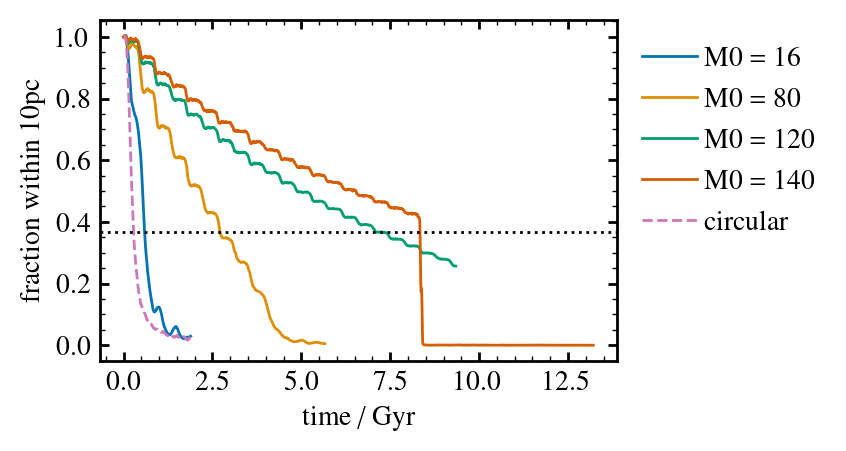

In [17]:
for i in range(len(directories)):
    Ms = calc_M_inside(directories[i])
    cen = get_centres(directories[i])
    plt.plot(cen.t * T0, Ms / Ms[0], label=f"M0 = {labels[i]}")
    
Ms = calc_M_inside("orbitc")
cen = get_centres("orbitc")
plt.plot(cen.t * T0, Ms / Ms[0], label="circular", ls="--")


plt.legend(loc="upper left", bbox_to_anchor=(1, 1)) # outside legend
plt.xlabel("time / Gyr")
plt.ylabel("fraction within 10pc")
plt.axhline(1/np.exp(1), color="k", ls=":")

To spare computer resources, I did not tune the initial masses very well. As we discussed in class, a remaining fraction of 1/e to characterize the disruption timescale. The 16 solar mass model disrupts rapidly in < 500Myr, irregardless of if the orbit is circular or not. However, the circular orbit has a much more continuous mass loss rate. The 80, 120, and 140 solar mass models instead has disruption timescales around 3, 7, and 10Gyrs. The 10Gyr model's mass drops to zero as the shirnking sphere's centres stop working as well (see last plot).

In [20]:
def plot_snap(directory, i, s=1, alpha=0.05):
    pos = get_positions(get_snap(get_snap_name(directory, i)))
    cen = get_x_cen(directory)
    plt.scatter(pos[0, :], pos[1, :], s=s, alpha=alpha)
    plt.scatter(cen[0, i], cen[1, i])
    radius = 0.01
    t = np.linspace(0, 2*np.pi, 1000)
    plt.plot(cen[0, i] + radius * np.cos(t), cen[1, i]  + radius* np.sin(t), color="k")
    plt.xlabel("x / kpc")
    plt.ylabel("y / kpc")

# Some orbit plots
the circles represent the 10 pc region used to characterized the remaining mass. The orange dot is the circle.

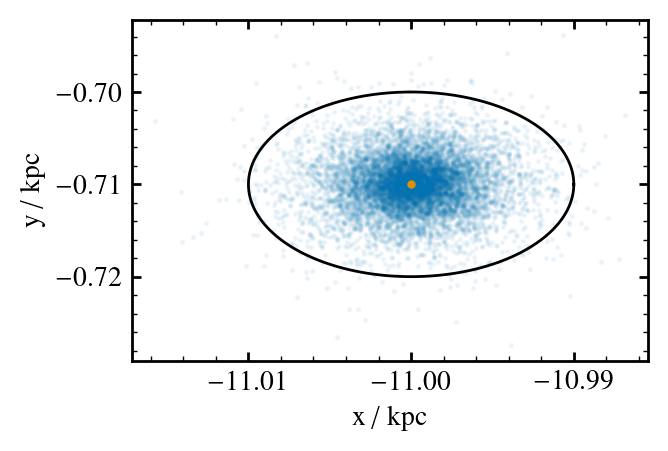

In [21]:
plot_snap("orbit1/", 0)

Initially a smooth, exponential, spherical profile.

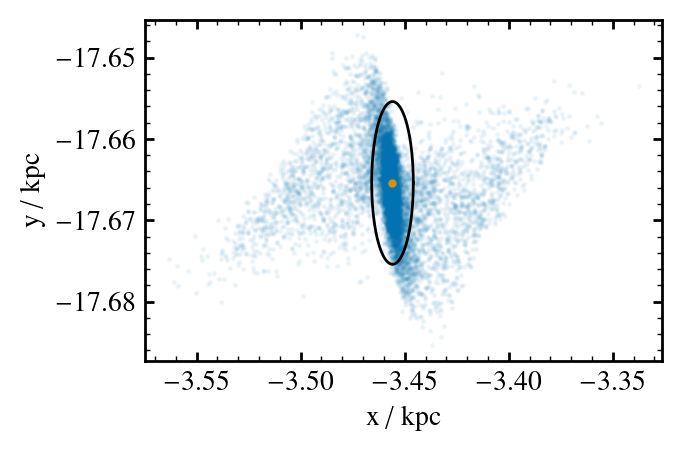

In [22]:
plot_snap("orbit1/", 100)


Some development of tidal tales

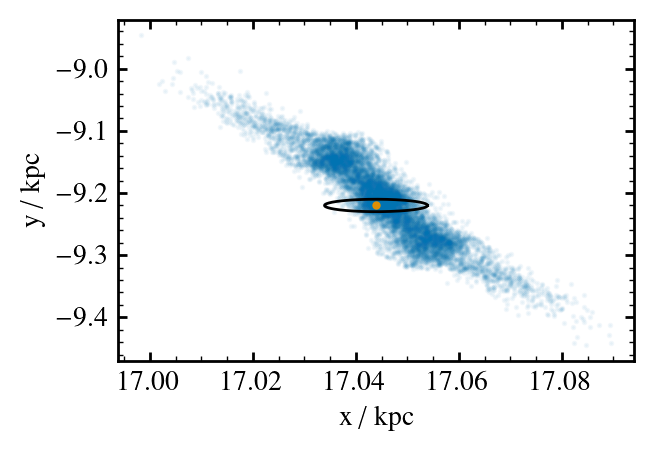

In [23]:
plot_snap("orbit1/", 200)

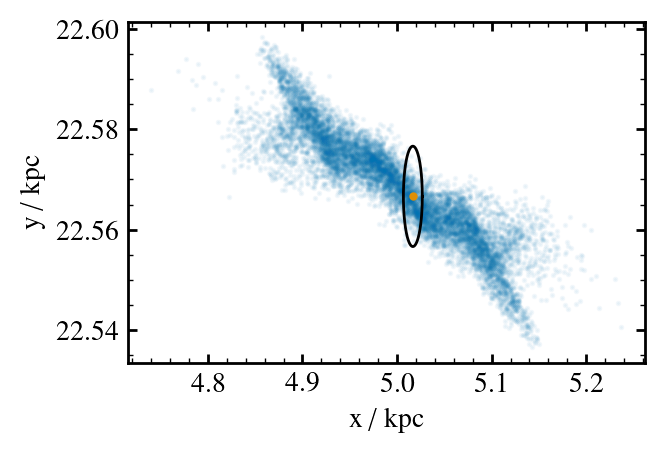

In [24]:
plot_snap("orbit1/", 300)

Bifurcation!

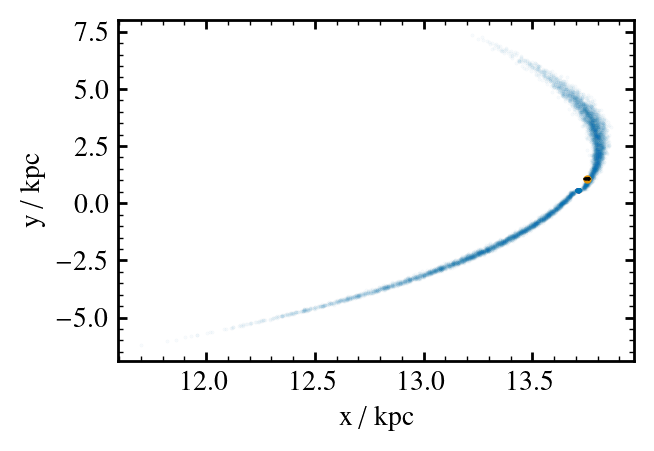

In [25]:
plot_snap("orbit5/", 2300, s=0.1)

A plot of the 140 initial mass model. At the end of the simulation, the centre is slightly off from the true centre. 